<a href="https://colab.research.google.com/github/RVasconcelosMiguel/ComputerVision/blob/main/C%C3%B3pia_de_CV_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tqdm

In [2]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
import zipfile


from PIL import Image
import zipfile

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [4]:
# Clear existing files or directories from previous runs
!rm -f -r "/content/images"
!rm -f "/content/module_metadata.json"

# Define paths for download and extraction
repo_path = "/content/InfraredSolarModules/"
zip_path = "/content/2020-02-14_InfraredSolarModules.zip"
extract_path = "/content"

# Clone the repository and extract the zip file
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git $repo_path
!mv "$repo_path/2020-02-14_InfraredSolarModules.zip" $extract_path
!unzip -uq $zip_path -d $extract_path

# Move images folder to the root directory
image_folder_path = "/content/InfraredSolarModules/images"
!mv $image_folder_path $extract_path

# Move module_metadata.json to the root directory
metadata_file_path = "/content/InfraredSolarModules/module_metadata.json"
!mv $metadata_file_path $extract_path

# Verify the final structure
!ls /content


Cloning into '/content/InfraredSolarModules'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 24 (delta 10), reused 12 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 5.49 MiB | 19.44 MiB/s, done.
Resolving deltas: 100% (10/10), done.
2020-02-14_InfraredSolarModules.zip  InfraredSolarModules  module_metadata.json
images				     __MACOSX		   sample_data


In [40]:
# Path to metadata JSON file
metadata_path = '/content/module_metadata.json'

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Convert metadata to DataFrame
df = pd.DataFrame.from_dict(metadata, orient='index')

# Binary Classification DataFrame
df_binary = df.copy()
df_binary['anomaly_class'] = df_binary['anomaly_class'].apply(
    lambda x: 1 if x.lower() != 'no-anomaly' else 0
)

# Display DataFrame details
print("*************** Binary Classification DataFrame ***************")
print(df_binary.head())
print("Total rows:", df_binary.shape[0])

train_ratio = 0.9
test_ratio = 0.1
train_data, test_data = train_test_split(df_binary, test_size=test_ratio, train_size=train_ratio, random_state=2, stratify=df_binary['anomaly_class'])

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


*************** Binary Classification DataFrame ***************
         image_filepath  anomaly_class
13357  images/13357.jpg              0
13356  images/13356.jpg              0
19719  images/19719.jpg              0
11542  images/11542.jpg              0
11543  images/11543.jpg              0
Total rows: 20000


In [41]:
"""
train_data, test_data=train_test_split(df_binary, test_size=0.15,train_size=0.85, random_state=2, stratify=df_binary["anomaly_class"])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
"""



'\ntrain_data, test_data=train_test_split(df_binary, test_size=0.15,train_size=0.85, random_state=2, stratify=df_binary["anomaly_class"])\ntrain_data.reset_index(drop=True, inplace=True)\ntest_data.reset_index(drop=True, inplace=True)\n'

ESTÁ IGUAL AO DO VITOR TEMOS QUE MUDAR DAQUI PARA BAIXO

In [42]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="RGB"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

"""
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None):
        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):#posteriormente o dataloader vai passar por todos os idx
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("L") # Abrir a imagem como RGB
        label = self.img_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)
"""


'\nclass MyImageDataset(data.Dataset):\n    def __init__(self, metadata, transform=None):\n        self.img_labels = metadata["anomaly_class"].values\n        self.img_paths = metadata["image_filepath"].values\n        self.transform = transform\n\n    def __len__(self):\n        return len(self.img_labels)\n\n    def __getitem__(self, idx):#posteriormente o dataloader vai passar por todos os idx\n        img_path = self.img_paths[idx]\n        image = Image.open(img_path).convert("L") # Abrir a imagem como RGB\n        label = self.img_labels[idx]\n\n        if self.transform:\n            image = self.transform(image)\n\n        return image, torch.tensor(label, dtype=torch.long)\n'

In [58]:
# Transformações
transform = transforms.Compose([

    transforms.ToTensor(),  # Converte para tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliza
])

# Datasets
train_dataset = MyImageDataset(metadata=train_data, transform=transform)
test_dataset = MyImageDataset(metadata=test_data, transform=transform)

# DataLoaders
batch_size = 32
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



torch.Size([3, 40, 24])


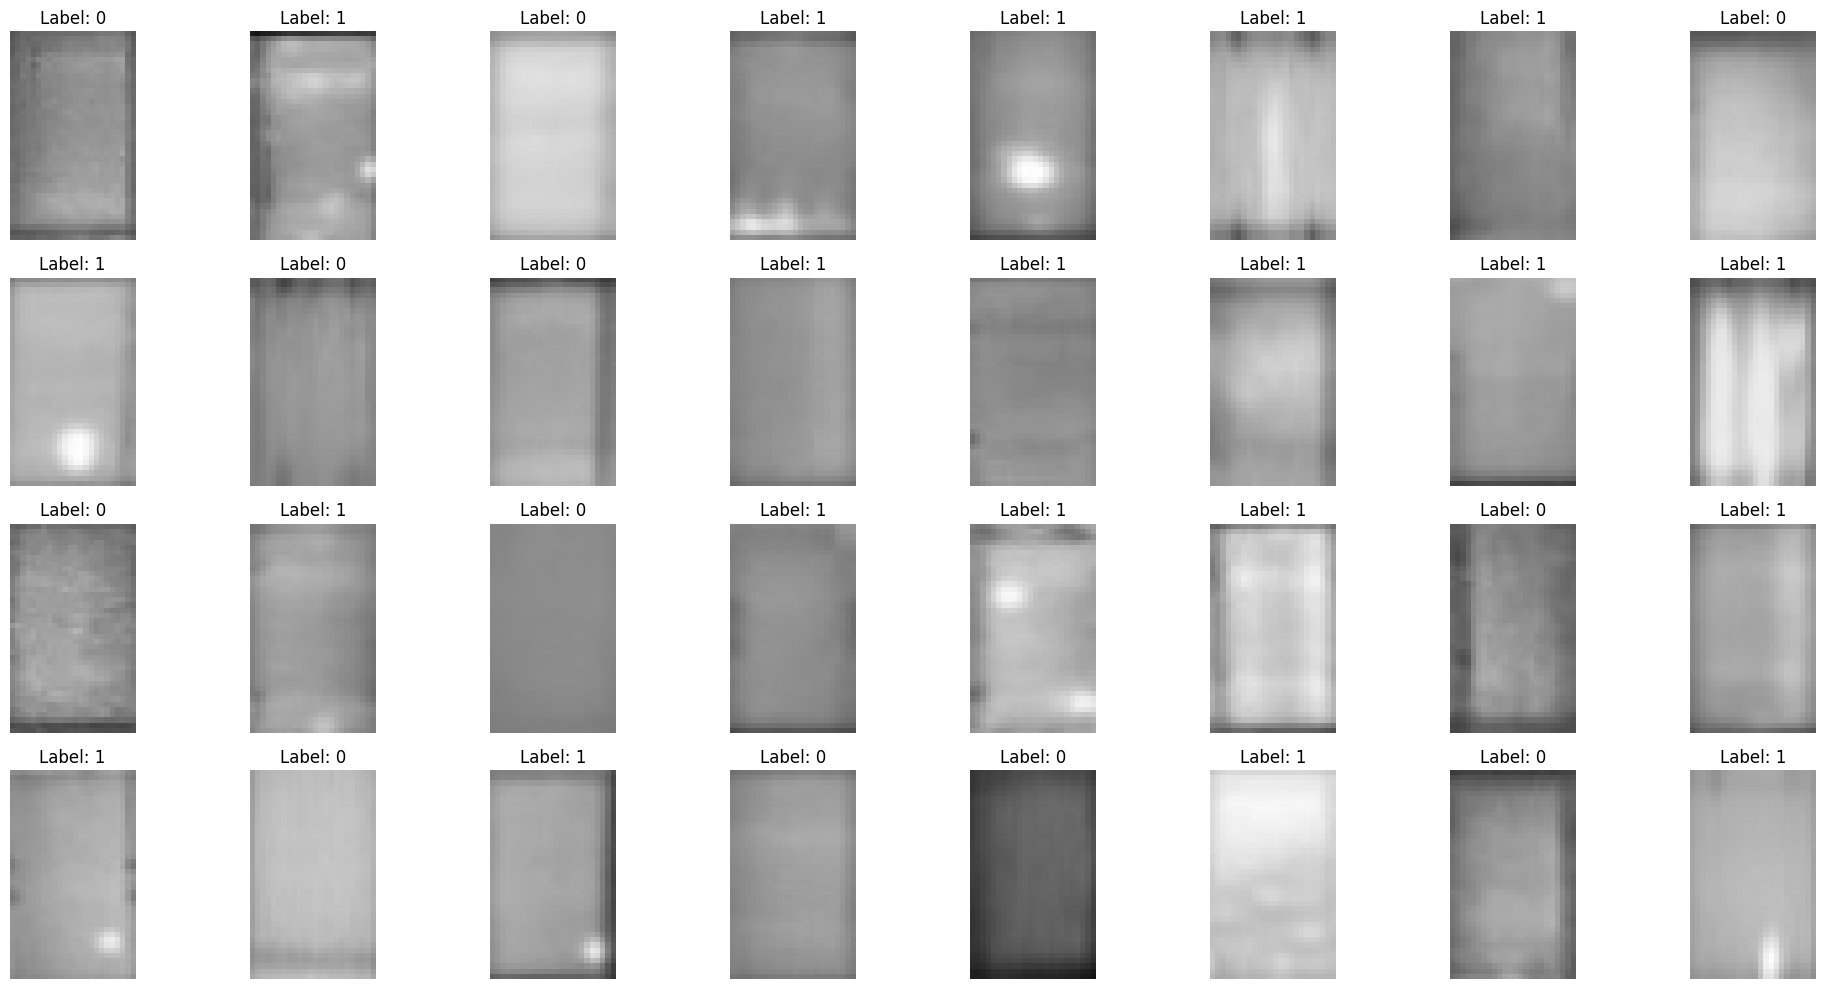

In [59]:
# Obtém um batch de imagens, seus rótulos e os caminhos
images, labels = next(iter(train_loader))  # Pega o primeiro batch

# Desfazendo a normalização para as imagens
images = images * 0.5 + 0.5  # Inverte a normalização, para voltar ao intervalo [0, 1]

# Cria uma figura com múltiplos subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4 linhas e 8 colunas
axes = axes.flatten()  # Para facilitar o acesso aos eixos (axes)

# Loop para exibir as 32 primeiras imagens do batch
for i in range(len(images)):
    image = images[i]  # Pega a i-ésima imagem do batch
    image_pil = transforms.ToPILImage()(image)  # Converte o tensor para uma imagem PIL

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels[i].item()}")  # Exibe o rótulo e o caminho do arquivo
    axes[i].axis('off')  # Remove os eixos para uma exibição mais limpa

print(images[0].shape)
plt.tight_layout()  # Ajusta o layout para que as imagens não se sobreponham
plt.show()







In [60]:

#Mesmo da prática
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional and pooling layers with kernel size 5x5 for the first two layers, 3x3 for the third layer
        self.conv1 = nn.Conv2d(3, 256, 5)  # Kernel size 5x5
        self.bn1 = nn.BatchNorm2d(256)

        self.conv2 = nn.Conv2d(256, 512, 5)  # Kernel size 5x5
        self.bn2 = nn.BatchNorm2d(512)
        self.pool1 = nn.MaxPool2d(2, 2)  # Max pool layer (2x2)

        self.dropout1 = nn.Dropout2d(0.2)  # Using dropout after convolutions

        self.conv3 = nn.Conv2d(512, 1024, 5)  # Kernel size 3x3 (adjusted for valid output size)
        self.bn3 = nn.BatchNorm2d(1024)

        self.conv4 = nn.Conv2d(1024, 2048, 3)  # Kernel size 3x3 (adjusted for valid output size)
        self.bn4 = nn.BatchNorm2d(2048)

        # Calculating the correct input size for the fully connected layer  | (size-kernel+1) |
        # Ini        : (40, 24)
        # After conv1: (36, 20)
        # After conv2: (32, 16)
        # After pool1: (16, 8)
        # After conv3: (12, 4)
        # After conv4: (10, 2)

        self.fc1 = nn.Linear(2048 * 10 * 2, 2048)  # Linear
        self.dropout_fc1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(2048, 1024)
        self.dropout_fc2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(1024, 512)
        self.dropout_fc3 = nn.Dropout(p=0.5)

        self.fc4 = nn.Linear(512, 1)

    def forward(self, x):
        # First convolutional layer, ReLU, and pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1)

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout_fc3(x)
        x = torch.sigmoid(self.fc4(x))

        return x

model = Network()
# Define the loss function
loss_fn = nn.BCEWithLogitsLoss().to(device)

# Define the optimizer
optimizer = SGD(model.parameters(), lr=0.0025, momentum=0.9)

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm

# Function to save the model
def saveModel(model: nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = 0.0
    best_epoch = 0
    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):  # Adding progress bar for epochs
        train_acc = 0.0
        train_loss = 0.0
        for ibatch, (images, labels) in enumerate(dataloader):  # Adding progress bar for batches

            # Get the inputs
            images = images.to(device)
            labels = labels.to(device)

            # 1. Forward pass
            y_pred = model(images)  # Model output (logits)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred.squeeze(), labels.float())  # BCEWithLogitsLoss expects float labels
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = (torch.sigmoid(y_pred) > 0.5).long()  # Convert logits to binary class (0 or 1)
            train_acc += (y_pred_class == labels).sum().item() / len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)

        # Save the model if the accuracy is the best
        if train_acc > best_accuracy:
            path = str(path_model)
            saveModel(model, path=path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            if verbatim:
                print('Best Epoch #', epoch, ' Loss=', best_loss, " Accu=", best_accuracy)

    return best_loss, best_accuracy, best_epoch


In [62]:
# Function to test the model with the test dataset and print the accuracy for the test images
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim=True):
    # Put model in eval mode
    model.eval()
    model.to(device)

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    pred_labels = []

    with torch.no_grad():
        for data in dataloader:
            # Get the inputs
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # 1. Run the model on the test set to predict labels
            y_pred = model(images)  # Model output (logits)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred.squeeze(), labels.float())  # BCEWithLogitsLoss expects float labels
            test_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            y_pred_class = (torch.sigmoid(y_pred) > 0.5).long()  # Convert logits to binary class (0 or 1)
            test_acc += (y_pred_class == labels).sum().item() / len(y_pred)
            pred_labels = y_pred_class.tolist()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    if verbatim:
        print("Loss =", test_loss, "  Accuracy=", test_acc)

    return pred_labels, test_loss, test_acc


In [ ]:
if __name__ == "__main__":

    model = model.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model,
                                                    dataloader=train_loader,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 30,
                                                    path_model = str("./myModel_best_A.pth"),
                                                    verbatim = True)

Epochs:   3%|▎         | 1/30 [01:42<49:20, 102.08s/epoch]

Best Epoch # 0  Loss= 0.6628650020324951  Accu= 15.985790408525755


Epochs:  27%|██▋       | 8/30 [12:53<35:42, 97.39s/epoch]

Best Epoch # 7  Loss= 0.5686985601540357  Accu= 15.990674955595027


Epochs:  37%|███▋      | 11/30 [17:48<31:23, 99.16s/epoch]

Best Epoch # 10  Loss= 0.5605487908711442  Accu= 15.999444937833037


Epochs:  43%|████▎     | 13/30 [21:11<28:35, 100.92s/epoch]

Best Epoch # 12  Loss= 0.5583745964784605  Accu= 16.017761989342805


Epochs:  47%|████▋     | 14/30 [22:54<27:04, 101.53s/epoch]

Best Epoch # 13  Loss= 0.5565709110157527  Accu= 16.034302841918294


Epochs:  53%|█████▎    | 16/30 [26:18<23:51, 102.21s/epoch]

Best Epoch # 15  Loss= 0.5548820842858107  Accu= 16.046070159857905


Epochs:  60%|██████    | 18/30 [29:34<20:05, 100.42s/epoch]

Best Epoch # 17  Loss= 0.5531488371149473  Accu= 16.05284191829485


Epochs:  63%|██████▎   | 19/30 [31:55<20:37, 112.54s/epoch]

Best Epoch # 18  Loss= 0.5513421003284928  Accu= 16.089920071047956


Epochs:  67%|██████▋   | 20/30 [33:34<18:05, 108.59s/epoch]

Best Epoch # 19  Loss= 0.5504125900315138  Accu= 16.0996891651865


Epochs:  70%|███████   | 21/30 [35:28<16:31, 110.20s/epoch]

Best Epoch # 20  Loss= 0.5497505941145373  Accu= 16.116341030195382


Epochs:  80%|████████  | 24/30 [40:19<10:12, 102.03s/epoch]

Best Epoch # 23  Loss= 0.5458834109361388  Accu= 16.13376998223801


Epochs:  90%|█████████ | 27/30 [45:14<05:01, 100.63s/epoch]

Best Epoch # 26  Loss= 0.5452211578087104  Accu= 16.14764653641208


Epochs:  93%|█████████▎| 28/30 [47:02<03:25, 102.84s/epoch]

Best Epoch # 27  Loss= 0.5439578092013541  Accu= 16.17317939609236


In [ ]:
y_pred, test_loss, test_acc  = test(model=model,
                                    dataloader=test_loader,
                                    loss_fn=loss_fn,
                                    device=device,
                                    verbatim = True)